# Chained deep learning using generalized cross entropy for multiple annotators segmentation



## Loss functions for segmentation in deep learning


Given a $k$ class multiple annotators segmentation problem with a dataset like the following'

$$\mathbf X \in \mathbb{R}^{W \times H}, \{ \mathbf Y_r \in \{0,1\}^{W \times H \times K} \}_{r=1}^R; \;\; \mathbf {\hat Y} \in [0,1]^{W\times H \times K} = f(\mathbf X)$$

The segmentation mask function will map input output as follows:

$$f: \mathbb  R ^{W\times H} \to [0,1]^{W\times H\times K}$$

$\mathbf Y$ will satisfy the following condition for being a softmax-like representation:

$$\mathbf Y_r[w,h,:] \mathbf{1} ^ \top _ k = 1; \;\; w \in W, h \in H$$

Now, let's suppose the existence of an annotators reliability map estimation $\Lambda_r; \; r \in R$;


$$\bigg\{ \Lambda_r (\mathbf X; \theta ) \in [0,1] ^{W\times H} \bigg\}_{r=1}^R $$

The reliability map of each annotator is penalized by the level of variability (entropy) of each annotation convolution;

$$\bigg\{ \textbf{E}\left( {\left( \textbf{X} \circ {\textbf{K}}_{k \times k} \right)}_{w \times h} \right)  \bigg\}_{r=1}^R; k \in \mathbb{N} $$

Then, our $TGCE_{SS}$:


$$TGCE_{SS}(\mathbf{Y}_r,f(\mathbf X;\theta) | \left( \mathbf{\Lambda}_r (\mathbf X;\theta)) - \textbf{E}\left( {\left( \textbf{X} \circ {\textbf{K}}_{k \times k} \right)}_{w \times h} \right) \right) =\mathbb E_{r} \left\{ \mathbb E_{w,h} \left\{ \Lambda_r (\mathbf X; \theta) \circ \mathbb E_k \bigg\{    \mathbf Y_r \circ \bigg( \frac{\mathbf 1 _{W\times H \times K} - f(\mathbf X;\theta) ^{\circ q }}{q} \bigg); k \in K  \bigg\}  + \\ \left(\mathbf 1 _{W \times H } - \left(\Lambda _r (\mathbf X;\theta)\right) - \textbf{E}\left( {\left( \textbf{X} \circ {\textbf{K}}_{k \times k} \right)}_{w \times h} \right)\right) \circ \bigg(   \frac{\mathbf 1_{W\times H} - (\frac {1}{k} \mathbf 1_{W\times H})^{\circ q}}{q} \bigg); w \in W, h \in H \right\};r\in R\right\} $$


Where $q \in (0,1)$

Total Loss for a given batch holding $N$ samples:

$$\mathscr{L}\left(\mathbf{Y}_r[n],f(\mathbf X[n];\theta) | \mathbf{\Lambda}_r (\mathbf X[n];\theta)\right)  = \frac{1}{N} \sum_{n}^NTGCE_{SS}(\mathbf{Y}_r[n],f(\mathbf X[n];\theta) | \mathbf{\Lambda}_r (\mathbf X[n];\theta))$$

$$$$

In [1]:
%%capture
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git >> /tmp/null
!pip install wandb
!pip install keras

# General Libraries
import os
import time
import random
import warnings
from enum import auto, Enum
from functools import partial
from datetime import datetime

# Image Processing Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.layers import Layer, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Machine Learning Libraries - Sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Deep Learning Libraries - GCPDS
from gcpds.image_segmentation.models import unet_baseline
from gcpds.image_segmentation.visualizations import plot_contour
from gcpds.image_segmentation.datasets.segmentation import OxfordIiitPet

# Deep Learning Libraries - TensorFlow specific
from tensorflow.keras.losses import Loss
from tensorflow.keras.metrics import Metric
from tensorflow.keras import Model, layers, regularizers

# Other Libraries
import gc
import json
import gdown
import itertools
from dataclasses import dataclass
from matplotlib.style import available
import wandb
from wandb.keras import WandbCallback
from tensorflow.python.framework.ops import EagerTensor

In [2]:
# Download OxfordPet Dataset

dataset = OxfordIiitPet()
train_dataset, val_dataset, test_dataset = dataset()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0KE07V/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0KE07V/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
# Download trained Unet network for OxfordPet segmentation task from Drive

model_url = "https://drive.google.com/file/d/1x39L3QNDMye1SJhKh1gf4YS-HRFLTs6G/view?usp=drive_link"
model_uri = model_url.split("/")[5]
!gdown $model_uri

model_extension = "keras"
paths = []

for file in os.listdir("."):
  if file.endswith(model_extension):
    paths.append(file)

model_path = paths[0]
print(f"Loading {model_path}...")
model_ann  = tf.keras.models.load_model(model_path, compile = False)

model_ann.summary()

Downloading...
From: https://drive.google.com/uc?id=1x39L3QNDMye1SJhKh1gf4YS-HRFLTs6G
To: /kaggle/working/oxford_pet_model_no_border2023-08-28 04 42 29.425657_dice0.826.keras
100%|██████████████████████████████████████| 6.24M/6.24M [00:00<00:00, 81.8MB/s]
Loading oxford_pet_model_no_border2023-08-28 04 42 29.425657_dice0.826.keras...
Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Batch00 (BatchNormalizatio  (None, 256, 256, 3)          12        ['input_3[0][0]']             
 n)                                                                                               
                                                        

In [4]:
# Find last encoder convolution layer

def find_last_encoder_conv_layer(model):
    '''
    Finds the index of the last convolutional layer in the encoder part of the model.

    Parameters:
    model (keras.Model): The Keras model to search for the last encoder convolutional layer.

    Returns:
    int: Index of the last convolutional layer in the encoder part of the model.
    '''
    
    last_conv_encoder_layer = 0
    for i,layer in enumerate(model.layers):
        if (isinstance(layer, keras.layers.Conv2D)):
          last_conv_encoder_layer = i
        if (isinstance(layer, keras.layers.UpSampling2D)):
          break
    return last_conv_encoder_layer

last_conv_encoder_layer = find_last_encoder_conv_layer(model_ann)
last_conv_encoder_layer

24

In [5]:
# Compute and add noise to the target layer

def compute_snr(signal:float, noise_std:float)->float:
  return  10 * np.log10(np.mean(signal ** 2)  / noise_std ** 2)

class SnrType(Enum):
  log = 0
  linear = 1

def add_noise_to_layer_weights(model, layer, noise_snr, snr_type: SnrType = SnrType.log, verbose = 0):
  layer_weights = model.layers[layer].get_weights()

  sig_power = np.mean(layer_weights[0] ** 2)

  if snr_type == SnrType.log:
    noise_power = sig_power / (10 ** (noise_snr / 10) )
  elif snr_type == SnrType.linear:
    noise_power = sig_power / noise_snr

  noise_std = noise_power ** ( 1 / 2)

  snr = compute_snr(layer_weights[0], noise_std)

  if verbose > 0 :
    print(f"Adding noise for snr: {noise_snr}\n\n")
    print(f"Signal power: {sig_power}")
    print(f"Noise power: {noise_power}\n\n")

  for i in range(layer_weights[0].shape[0]):
    for j in range(layer_weights[0].shape[1]):
      layer_weights[0][i][j] += np.random.randn(128,128) * noise_std

  model.layers[last_conv_encoder_layer].set_weights(layer_weights)
  return snr

In [6]:
# Define the signal-to-noise ratio values for each synthetic annotator 
values_to_test = [20,-10,0,10,-15]

# Creation of the different models and their perturbations starting from the base model
def produce_disturbed_models(values_to_test, base_model_path):
  snr_values = []
  models = []

  for value in values_to_test:
    model_ = tf.keras.models.load_model(base_model_path, compile = False)
    snr = add_noise_to_layer_weights(model_, last_conv_encoder_layer, value)
    snr_values.append(snr)
    models.append(model_)
  return models, snr_values

disturbance_models, snr_values = produce_disturbed_models(values_to_test, model_path)

In [7]:
# Disturbance processing with different SNR ratios values for each database partition using the modified networks

BATCH_SIZE = 32
TARGET_SHAPE = 256, 256
ORIGINAL_MODEL_SHAPE = 256, 256
NUM_ANNOTATORS = 5

def disturb_mask(model, image, model_shape, target_shape):
  return tf.image.resize(model(tf.image.resize(image, model_shape)), target_shape)

def mix_channels(mask, num_annotators):
  return tf.stack([mask, 1-mask], axis=-2)

def add_noisy_annotators(img: EagerTensor, models, model_shape, target_shape)->EagerTensor:
  return tf.transpose([disturb_mask(model, img, model_shape=model_shape, target_shape=target_shape) for model in models], [2,3,1,4,0])

def map_dataset_MA(dataset, target_shape, model_shape, batch_size, num_annotators):
    dataset_ = dataset.map(lambda img,mask,label,id_img: (img,mask),
                                      num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img,mask: (tf.image.resize(img,target_shape), tf.image.resize(mask,target_shape)),
                                    num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img,mask: (img, add_noisy_annotators(tf.expand_dims(img, 0), disturbance_models, model_shape=model_shape, target_shape=target_shape)),
                            num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img,mask: (img, tf.reshape(mask, (mask.shape[0], mask.shape[1], 1, mask.shape[-1] ))),
                           num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img,mask: (img, mix_channels(mask, num_annotators)),
                           num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img,mask: (img, tf.squeeze(mask, axis=2 )),
                           num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.batch(batch_size)
    return dataset_


train = map_dataset_MA(
    train_dataset,
    target_shape=TARGET_SHAPE,
    model_shape=ORIGINAL_MODEL_SHAPE,
    batch_size=BATCH_SIZE,
    num_annotators=NUM_ANNOTATORS)
val = map_dataset_MA(
    val_dataset,
    target_shape=TARGET_SHAPE,
    model_shape=ORIGINAL_MODEL_SHAPE,
    batch_size=BATCH_SIZE,
    num_annotators=NUM_ANNOTATORS)

test = map_dataset_MA(
    test_dataset,
    target_shape=TARGET_SHAPE,
    model_shape=ORIGINAL_MODEL_SHAPE,
    batch_size=BATCH_SIZE,
    num_annotators=NUM_ANNOTATORS)

Mask shape: (32, 256, 256, 2, 5) (batch_size * h * w * k * r) Img shape (32, 256, 256, 3)


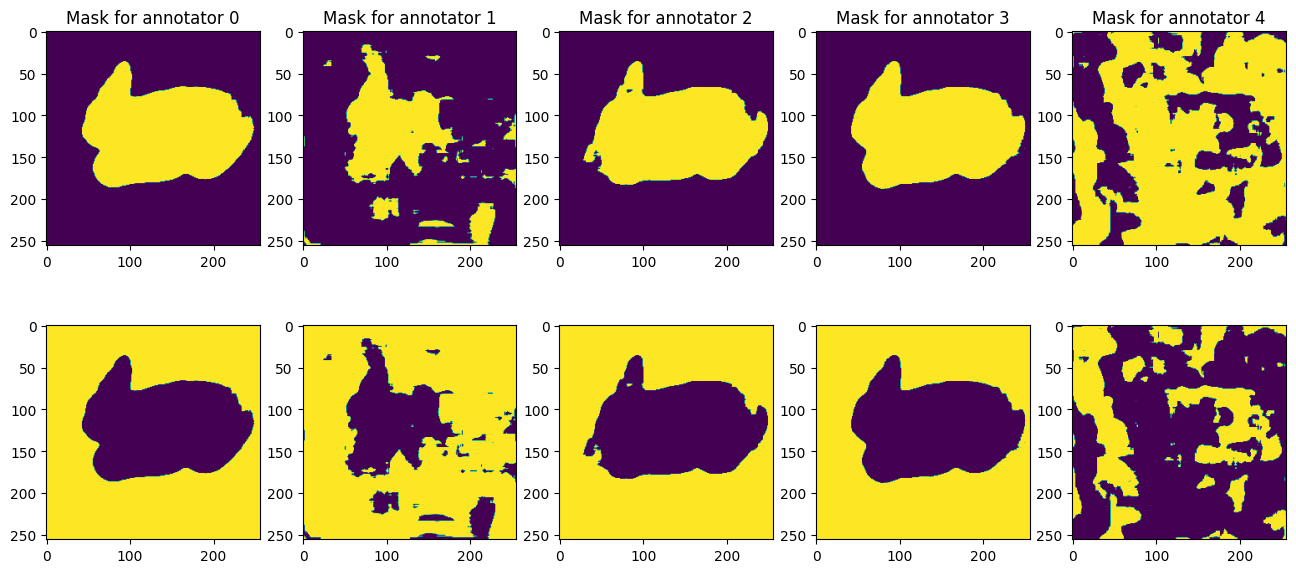

In [8]:
# Plotting the different perturbations to a sample and the resulting dimensions

for img,mask in train.take(1):
  print(f"Mask shape: {mask.shape} (batch_size * h * w * k * r) Img shape {img.shape}")
  fig, axes = plt.subplots(2,NUM_ANNOTATORS)
  fig.set_size_inches(16,7)
  for i in range(NUM_ANNOTATORS):
    axes[0][i].imshow((mask)[0,:,:,0,i])
    axes[0][i].set_title(f"Mask for annotator {i}")
    axes[1][i].imshow((mask)[0,:,:,-1,i])

In [9]:
# Custom loss function: TGCE SS

class TGCE_SS(Loss):
  def __init__(self, q=0.1, name='TGCE_SS',
               R=NUM_ANNOTATORS,K_=2,smooth=1e-5,
               **kwargs):
    self.q = q
    self.R = R
    self.K_ = K_
    self.smooth = smooth
    #self.total_loss = self.add_weight(name='total_loss', initializer='zeros')
    #self.total_term_r = self.add_weight(name='total_term_r', initializer='zeros')
    #self.total_term_c = self.add_weight(name='total_term_c', initializer='zeros')
    #self.num_samples = self.add_weight(name='num_samples', initializer='zeros')

    super().__init__(name=name,**kwargs)

  def call(self, y_true, y_pred):
    Lambda_r = y_pred[...,self.K_:] # Annotators reilability -> extra cnn upsampling layer
    #print(f"Minimum value: {tf.reduce_min(y_pred[num_img,:,:,2])} and Maximum value: {tf.reduce_max(y_pred[num_img,:,:,2])}")
    #print(f"Minimum value: {tf.reduce_min(y_pred[num_img,:,:,6])} and Maximum value: {tf.reduce_max(y_pred[num_img,:,:,6])}")
    y_pred_ = y_pred[...,:self.K_] # Segmented images from unet
    N,W,H,_ = y_pred_.shape
    y_pred_ = y_pred_[...,tf.newaxis]
    y_pred_ = tf.repeat(y_pred_,repeats=[self.R],axis=-1) # Repeat f(x)
    
    epsilon = 1e-8  # Small constant to avoid divisions by zero
    y_pred_ = tf.clip_by_value(y_pred_, epsilon, 1.0 - epsilon)  # Limiting values between epsilon and 1 - epsilon

    term_r = tf.math.reduce_mean(tf.math.multiply(y_true, (tf.ones([N, W, H, self.K_, self.R]) - tf.pow(y_pred_, self.q)) / (self.q + epsilon + self.smooth)), axis=-2)
    term_c = tf.math.multiply(tf.ones([N, W, H, self.R]) - Lambda_r, (tf.ones([N, W, H, self.R]) - tf.pow((1 / self.K_ + self.smooth) * tf.ones([N, W, H, self.R]), self.q)) / (self.q + epsilon + self.smooth))

    # Avoid NaN in final loss function
    loss = tf.math.reduce_mean(tf.math.multiply(Lambda_r, term_r) + term_c)
    if tf.math.is_nan(loss):
        loss = tf.where(tf.math.is_nan(loss), tf.constant(0.0), loss)  # Replace NaN with 0.0
        print ("Forced modification comes into action")
    return loss, term_r, term_c

  def get_config(self,):
    base_config = super().get_config()
    return {**base_config, "q": self.q}

In [10]:
# Definition of the Dice metric with coefficient

class DiceCoefficientMetric(Metric):

    def __init__(self,smooth=1.0, target_class=None, name='DiceCoefficientMetric',**kwargs):
        super().__init__(name=name,**kwargs)
        self.smooth = smooth
        self.target_class = target_class
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.compute(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))
        
    # Reset metric's states
    def reset_states(self):
        self.total.assign(0.0)
        self.count.assign(0.0)
    
    def result(self):
        return self.total/self.count 

    def compute(self, y_true, y_pred):
        intersection = K.sum(y_true * y_pred, axis=[1,2])
        union = K.sum(y_true,axis=[1,2]) + K.sum(y_pred,axis=[1,2])
        dice_coef = -(2. * intersection + self.smooth) /(union + self.smooth)
        
        if self.target_class != None:
            dice_coef = tf.gather(dice_coef,
                                  self.target_class, axis=1)
        else:
            dice_coef = K.mean(dice_coef,axis=-1)

        return dice_coef
    
    def get_config(self,):
        base_config = super().get_config()
        return {**base_config, "smooth": self.smooth,
                "target_class":self.target_class}

In [11]:
# Definition of the Jaccard metric with coefficient

class Jaccard(Metric):

    def __init__(self,smooth=1.0, target_class=None, name='Jaccard',**kwargs):
        super().__init__(name=name, **kwargs)
        self.smooth = smooth
        self.target_class = target_class
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
        

    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.compute(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))
    
    # Reset metric's states
    def reset_states(self):
        self.total.assign(0.0)
        self.count.assign(0.0)
    
    def result(self):
        return self.total/self.count 

    def compute(self, y_true, y_pred):
        intersection = K.sum(y_true * y_pred, axis=[1,2])
        union = K.sum(y_true, axis=[1,2]) + K.sum(y_pred, axis=[1,2])
        jaccard = (intersection + self.smooth) / (union - intersection + self.smooth)

        if self.target_class != None:
            jaccard = tf.gather(jaccard, 
                                self.target_class, axis=1)
        else: 
            jaccard = K.mean(jaccard,axis=-1)
            
        return jaccard

    
    def get_config(self,):
        base_config = super().get_config()
        return {**base_config, "smooth": self.smooth,
                "target_class":self.target_class}

In [12]:
# Definition of the Sensitivity metric with coefficient

class Sensitivity(Metric):

    def __init__(self, target_class=None, name='Sensitivity', **kwargs):
        super().__init__(name=name, **kwargs)
        self.target_class = target_class
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.sensitivity(y_true, y_pred, self.target_class)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))
    
    # Reset metric's states
    def reset_states(self):
        self.total.assign(0.0)
        self.count.assign(0.0)
    
    def result(self):
        return self.total/self.count 

    def compute(self,y_true, y_pred):
        return self.sensitivity(y_true, y_pred, self.target_class)

    @staticmethod
    def sensitivity(y_true, y_pred, target_class=None):
        y_true = tf.cast(y_true > 0.5,tf.float32)
        y_pred = tf.cast(y_pred > 0.5 ,tf.float32)
    
        true_positves = K.sum(y_true*y_pred,axis=[1,2])
        total_positives = K.sum(y_true,axis=[1,2])

        sensitivity = true_positves / (total_positives + K.epsilon())

        if target_class != None:
            sensitivity = tf.gather(sensitivity,
                                    target_class, axis=1)
        else:
            sensitivity = K.mean(sensitivity,axis=-1)
            
        return sensitivity
    
    def get_config(self,):
        base_config = super().get_config()
        return {**base_config, "target_class":self.target_class}

In [13]:
# Definition of the Specificity metric with coefficient

class Specificity(Metric):

    def __init__(self, target_class=None, name='Specificity',**kwargs):
        super().__init__(name=name, **kwargs)
        self.target_class = target_class
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.specificity(y_true, y_pred, self.target_class)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))
    
    # Reset metric's states
    def reset_states(self):
        self.total.assign(0.0)
        self.count.assign(0.0)
    
    def result(self):
        return self.total/self.count 

    def compute(self,y_true, y_pred):
        return self.specificity(y_true, y_pred, self.target_class)
    
    @staticmethod
    def specificity(y_true, y_pred, target_class=None):
        y_true = tf.cast(y_true < 0.5,tf.float32)
        y_pred = tf.cast(y_pred < 0.5 ,tf.float32)

        return Sensitivity.sensitivity(y_true, y_pred, target_class)
    
    def get_config(self,):
        base_config = super().get_config()
        return {**base_config, "target_class":self.target_class}

## Assembling UNet with Loss TGCE

In [14]:
# Definition of the neural network structure to implement the Loss TGCE SS 
# with custom activation functions and outputs of interest

DefaultConv2D = partial(layers.Conv2D,
                        kernel_size=3, activation='relu', padding="same")

DilatedConv = partial(layers.Conv2D,
                        kernel_size=3, activation='relu', padding="same", dilation_rate=10)

DefaultPooling = partial(layers.MaxPool2D,
                        pool_size=2)

upsample = partial(layers.UpSampling2D, (2,2))

def kernel_initializer(seed):
    return tf.keras.initializers.GlorotUniform(seed=seed)

class SparseSoftmax(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SparseSoftmax, self).__init__(**kwargs)

    def build(self, input_shape):
        super(SparseSoftmax, self).build(input_shape)

    def call(self, x):
        e_x = K.exp(x - K.max(x, axis=-1, keepdims=True))
        sum_e_x = K.sum(e_x, axis=-1, keepdims=True)
        output = e_x / (sum_e_x + K.epsilon())
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

class SoftmaxCustom(Layer):
    def __init__(self, sup_limit, inf_limit, **kwargs):
        super(SoftmaxCustom, self).__init__(**kwargs)
        self.sup_limit = sup_limit
        self.inf_limit = inf_limit

    def build(self, input_shape):
        super(SoftmaxCustom, self).build(input_shape)

    def call(self, x):
        return K.softmax(x) * (self.sup_limit - self.inf_limit) + self.inf_limit

    def compute_output_shape(self, input_shape):
        return input_shape

def unet_tgce(input_shape=(128,128,3), name='UNET', out_channels=2, out_ActFunction = SparseSoftmax(), n_scorers = 5, out_ActFunction_Lambda = SparseSoftmax()):#SoftmaxCustom(sup_limit=0.9, inf_limit=0.1)):
  # Encoder
  input = layers.Input(shape=input_shape)

  x =  layers.BatchNormalization(name='Batch00')(input)

  x = DefaultConv2D(8,kernel_initializer=kernel_initializer(34),name='Conv10')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch10')(x)
  x = level_1 = DefaultConv2D(8,kernel_initializer=kernel_initializer(4),name='Conv11')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch11')(x)
  x = DefaultPooling(name='Pool10')(x) # 128x128 -> 64x64

  x = DefaultConv2D(16,kernel_initializer=kernel_initializer(56),name='Conv20')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch20')(x)
  x = level_2 = DefaultConv2D(16,kernel_initializer=kernel_initializer(32),name='Conv21')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch22')(x)
  x = DefaultPooling(name='Pool20')(x) # 64x64 -> 32x32


  x = DefaultConv2D(32,kernel_initializer=kernel_initializer(87),name='Conv30')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch30')(x)
  x = level_3 = DefaultConv2D(32,kernel_initializer=kernel_initializer(30),name='Conv31')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch31')(x)
  x = DefaultPooling(name='Pool30')(x) # 32x32 -> 16x16

  x = DefaultConv2D(64,kernel_initializer=kernel_initializer(79),name='Conv40')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch40')(x)
  x = level_4 = DefaultConv2D(64,kernel_initializer=kernel_initializer(81),name='Conv41')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch41')(x)
  x = DefaultPooling(name='Pool40')(x) # 16x16 -> 8x8


  #Decoder
  x = DefaultConv2D(128,kernel_initializer=kernel_initializer(89),name='Conv50')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch50')(x)
  x = DefaultConv2D(128,kernel_initializer=kernel_initializer(42),name='Conv51')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch51')(x)


  x = upsample(name='Up60')(x) # 8x8 -> 16x16
  x = layers.Concatenate(name='Concat60')([level_4,x])
  x = DefaultConv2D(64,kernel_initializer=kernel_initializer(91),name='Conv60')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch60')(x)
  x = DefaultConv2D(64,kernel_initializer=kernel_initializer(47),name='Conv61')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch61')(x)

  x = upsample(name='Up70')(x) # 16x16 -> 32x32
  x = layers.Concatenate(name='Concat70')([level_3,x])
  x = DefaultConv2D(32,kernel_initializer=kernel_initializer(21),name='Conv70')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch70')(x)
  x = DefaultConv2D(32,kernel_initializer=kernel_initializer(96),name='Conv71')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch71')(x)

  x = upsample(name='Up80')(x) # 32x32 -> 64x64
  x = layers.Concatenate(name='Concat80')([level_2,x])
  x = DefaultConv2D(16,kernel_initializer=kernel_initializer(96),name='Conv80')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch80')(x)
  x = DefaultConv2D(16,kernel_initializer=kernel_initializer(98),name='Conv81')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch81')(x)

  x = upsample(name='Up90')(x) # 64x64 -> 128x128
  x = layers.Concatenate(name='Concat90')([level_1,x])
  x = DefaultConv2D(8,kernel_initializer=kernel_initializer(35),name='Conv90')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch90')(x)
  x = DefaultConv2D(8,kernel_initializer=kernel_initializer(7),name='Conv91')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.BatchNormalization(name='Batch91')(x)

  xy = DefaultConv2D(out_channels,kernel_size=(1,1),activation=out_ActFunction,
                      kernel_initializer=kernel_initializer(42),
                      name='Conv100')(x)
  x_lambda = DilatedConv(n_scorers,kernel_size=(1,1),activation= out_ActFunction_Lambda,
                        kernel_initializer=kernel_initializer(42), 
                        name='DilatedConv101-Lambda')(x)
  y = layers.Concatenate(name='Concat100')([xy,x_lambda])

  model = Model(input,y,name=name)

  return model

In [15]:
# Compilation of the model with relevant adjustments

model = unet_tgce(
    input_shape = TARGET_SHAPE + (3,),
    out_channels= 2, 
    n_scorers= NUM_ANNOTATORS )#TARGET_SHAPE + (3,)
model.compile(
    loss=TGCE_SS(q=0.1,R=NUM_ANNOTATORS,K_=2),
    #metrics = DiceCoefficientMetric(), Jaccard(), Sensitivity(), Specificity(),
    optimizer=tf.keras.optimizers.Adam(),)
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Batch00 (BatchNormalizatio  (None, 256, 256, 3)          12        ['input_1[0][0]']             
 n)                                                                                               
                                                                                                  
 Conv10 (Conv2D)             (None, 256, 256, 8)          224       ['Batch00[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 8)          0         ['Conv10[0][0]']           

In [16]:
# Model's output shape: the first last two dimensions are segmentation and the last five dimensions are scorer performance

model.output_shape

(None, 256, 256, 7)

In [17]:
# Loading of the training part of the database in a tensor manner

X_train = []
y_train = []

for img, mask in train.take(21):
    img_1 = img
    mask_1 = mask
    X_train.append(img_1)
    y_train.append(mask_1)

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


In [18]:
# Loading of the validation part of the database in a tensor manner

X_val = []
y_val = []

for img, mask in val.take(5):
    img_1 = img
    mask_1 = mask
    X_val.append(img_1)
    y_val.append(mask_1)

In [19]:
# Loading of the testing part of the database in a tensor manner

X_test = []
y_test = []

for img, mask in test.take(5):
    img_1 = img
    mask_1 = mask
    X_test.append(img_1)
    y_test.append(mask_1)

In [20]:
# Plot function to show the segmentation performance of the network and each annotator

def plotter_fn(predictions, x_batch, num_img_batch, num_img_pred):   
    
    # Create figure and subplots
    if predictions.shape[-1] >= 3:
        fig, axes = plt.subplots(2, predictions.shape[-1] - 2, figsize=(15, 6))
        for i in range(3, predictions.shape[-1] - 2):
            axes[0,i].axis('off')
    else:
        fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    
    # First row of images
    axes[0, 0].imshow(x_batch[num_img_batch,:,:,:])
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    channel_1 = predictions[num_img_pred, :, :, 0]
    channel_1 = tf.where(channel_1 < 0.5, 0.0, 1.0)
    axes[0, 1].imshow(tf.math.log(channel_1))
    axes[0, 1].set_title('Segmented image - Channel 1')
    axes[0, 1].axis('off')

    channel_2 = predictions[num_img_pred, :, :, 1]
    channel_2 = tf.where(channel_2 < 0.5, 0.0, 1.0)                 
    axes[0, 2].imshow(tf.math.log(channel_2))
    axes[0, 2].set_title('Segmented image - Channel 2')
    axes[0, 2].axis('off')
    
    # Second row of images
    
    # Define visualization range from 0 to 1
    vmin = 0.0
    vmax = 1.0
    tensors_list=[]
    
    for i in range(0, predictions.shape[-1] - 2):
        axes[1,i].imshow(predictions[num_img_pred, :, :, i+2], vmin=vmin, vmax=vmax)
        tensors_list.append(predictions[num_img_pred, :, :, i+2])
        axes[1, i].set_title(f'Annotator - {i+1} $\lambda$: {np.mean(predictions[num_img_pred, :, :, i+2]):.3f}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()
        
    sum_tensors = tf.reduce_sum(tensors_list, axis=0)  # Sum along axis 0
    print(sum_tensors)

In [21]:
def compute_regularization_loss(model, lambda1: float, lambda2: float)->float:
    l1_loss = tf.add_n([tf.reduce_sum(tf.abs(w)) for w in model.trainable_weights if 'bias' not in w.name]) * lambda1
    l2_loss = tf.add_n([tf.reduce_sum(tf.square(w)) for w in model.trainable_weights if 'bias' not in w.name]) * lambda2
    return l1_loss + l2_loss

Epoch 1/100
Training time: 40.197s
Loss: 12.746, Dice: -0.539, Jaccard: 0.378, Specificity: 0.612, Sensitivity: 0.612
Val_Loss: 0.602, Val_Dice: -0.486, Val_Jaccard: 0.328, Val_Specificity: 0.500, Val_Sensitivity: 0.500
Epoch 2/100
Training time: 22.861s
Loss: 12.349, Dice: -0.616, Jaccard: 0.455, Specificity: 0.763, Sensitivity: 0.763
Val_Loss: 0.600, Val_Dice: -0.496, Val_Jaccard: 0.338, Val_Specificity: 0.500, Val_Sensitivity: 0.500
Epoch 3/100
Training time: 22.804s
Loss: 12.221, Dice: -0.669, Jaccard: 0.515, Specificity: 0.799, Sensitivity: 0.799
Val_Loss: 0.601, Val_Dice: -0.491, Val_Jaccard: 0.345, Val_Specificity: 0.500, Val_Sensitivity: 0.500
Epoch 4/100
Training time: 22.057s
Loss: 12.124, Dice: -0.704, Jaccard: 0.555, Specificity: 0.823, Sensitivity: 0.823
Val_Loss: 0.607, Val_Dice: -0.471, Val_Jaccard: 0.341, Val_Specificity: 0.500, Val_Sensitivity: 0.500
Epoch 5/100
Training time: 22.494s
Loss: 12.077, Dice: -0.718, Jaccard: 0.572, Specificity: 0.828, Sensitivity: 0.828
Va

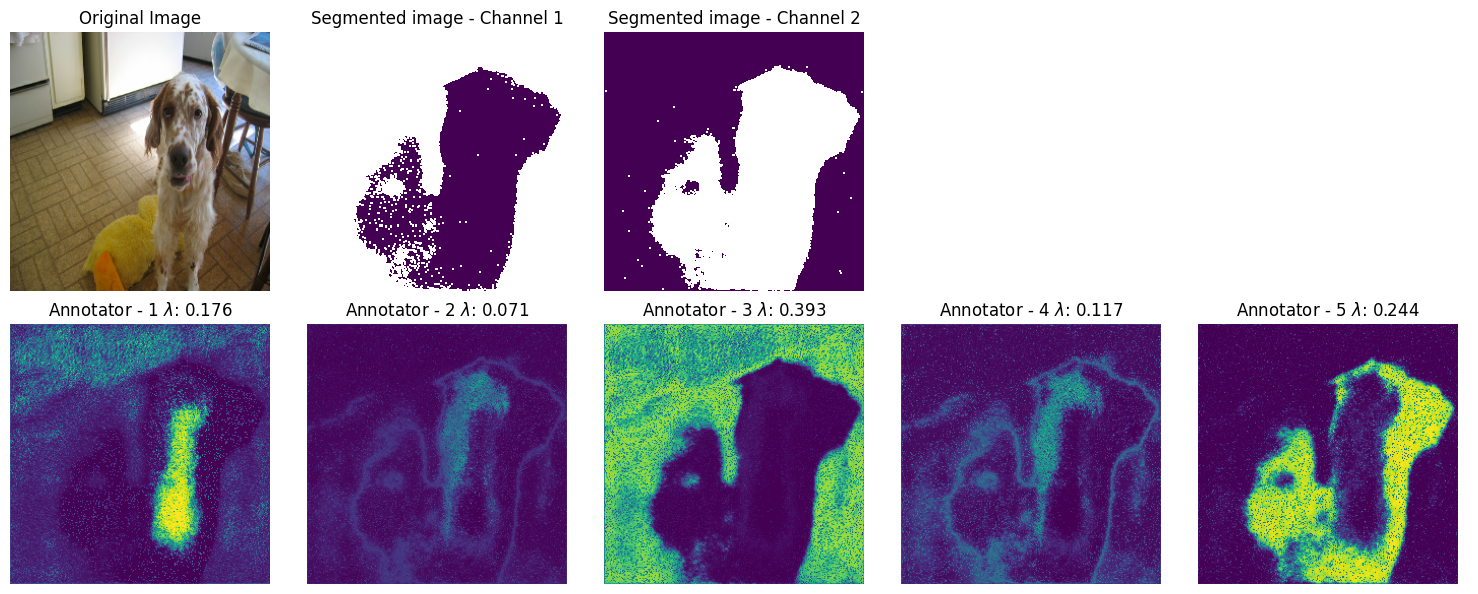

tf.Tensor(
[[1.         1.         0.99999994 ... 1.         1.         1.        ]
 [1.         0.9999999  0.99999976 ... 0.9999999  0.9999999  0.9999999 ]
 [0.99999994 0.99999994 1.         ... 0.99999994 0.9999998  0.9999998 ]
 ...
 [1.0000001  0.9999998  0.9999998  ... 0.99999994 0.9999999  0.99999994]
 [0.99999994 0.9999999  0.99999994 ... 1.0000001  0.9999999  0.9999999 ]
 [1.         0.9999999  0.99999994 ... 1.         0.99999994 1.        ]], shape=(256, 256), dtype=float32)
Learning Rate in epoch 10: 0.0010000000474974513
Epoch 11/100
Training time: 23.072s
Loss: 11.869, Dice: -0.784, Jaccard: 0.657, Specificity: 0.864, Sensitivity: 0.864
Val_Loss: 0.611, Val_Dice: -0.591, Val_Jaccard: 0.469, Val_Specificity: 0.636, Val_Sensitivity: 0.636
Epoch 12/100
Training time: 22.951s
Loss: 11.860, Dice: -0.787, Jaccard: 0.661, Specificity: 0.864, Sensitivity: 0.864
Val_Loss: 0.587, Val_Dice: -0.698, Val_Jaccard: 0.565, Val_Specificity: 0.730, Val_Sensitivity: 0.730
Epoch 13/100
Trainin

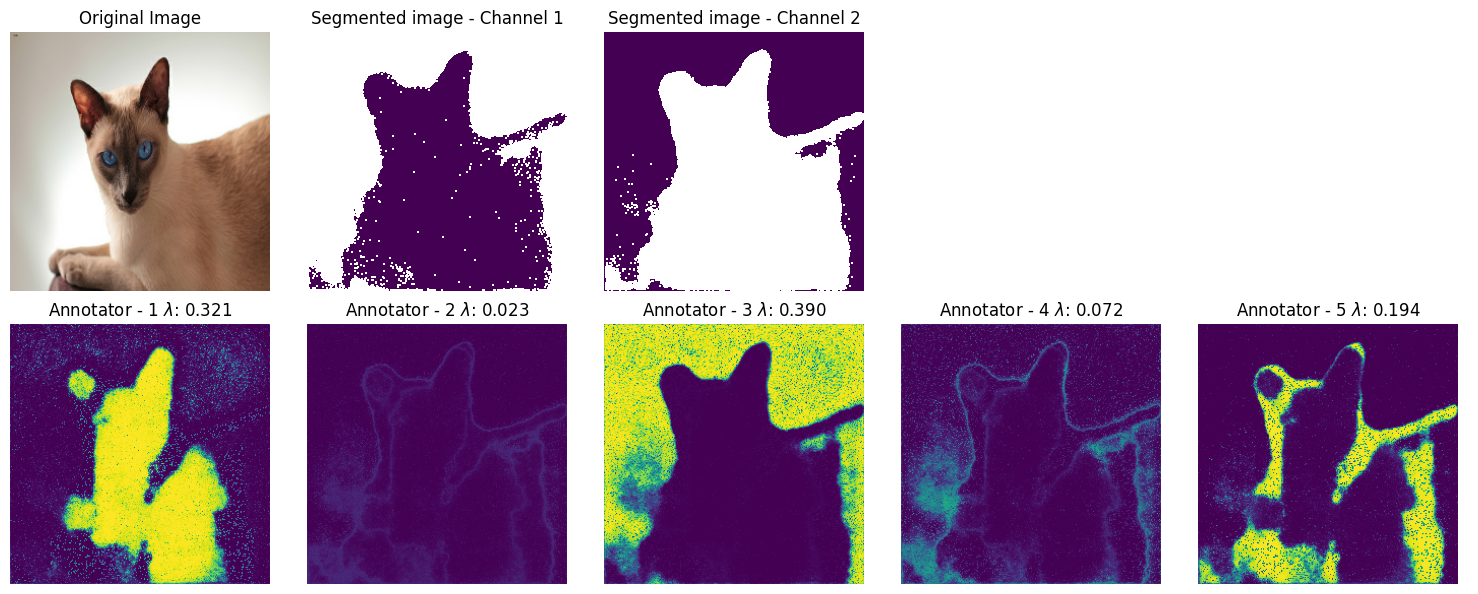

tf.Tensor(
[[1.         0.9999999  0.99999994 ... 0.99999994 0.99999994 1.        ]
 [0.9999999  0.9999998  1.         ... 0.9999999  0.9999999  0.99999994]
 [0.9999999  0.99999994 0.99999994 ... 0.99999994 0.99999994 0.9999999 ]
 ...
 [0.99999994 1.         0.9999999  ... 0.9999999  0.99999994 0.9999999 ]
 [1.         1.         0.99999994 ... 0.9999999  1.         0.99999994]
 [1.         1.0000001  1.0000001  ... 0.9999998  0.9999998  0.9999999 ]], shape=(256, 256), dtype=float32)
Learning Rate in epoch 20: 0.0010000000474974513
Epoch 21/100
Training time: 22.978s
Loss: 11.660, Dice: -0.848, Jaccard: 0.746, Specificity: 0.900, Sensitivity: 0.900
Val_Loss: 0.575, Val_Dice: -0.787, Val_Jaccard: 0.673, Val_Specificity: 0.798, Val_Sensitivity: 0.798
Epoch 22/100
Training time: 22.045s
Loss: 11.658, Dice: -0.848, Jaccard: 0.746, Specificity: 0.900, Sensitivity: 0.900
Val_Loss: 0.565, Val_Dice: -0.847, Val_Jaccard: 0.751, Val_Specificity: 0.869, Val_Sensitivity: 0.869
Epoch 23/100
Trainin

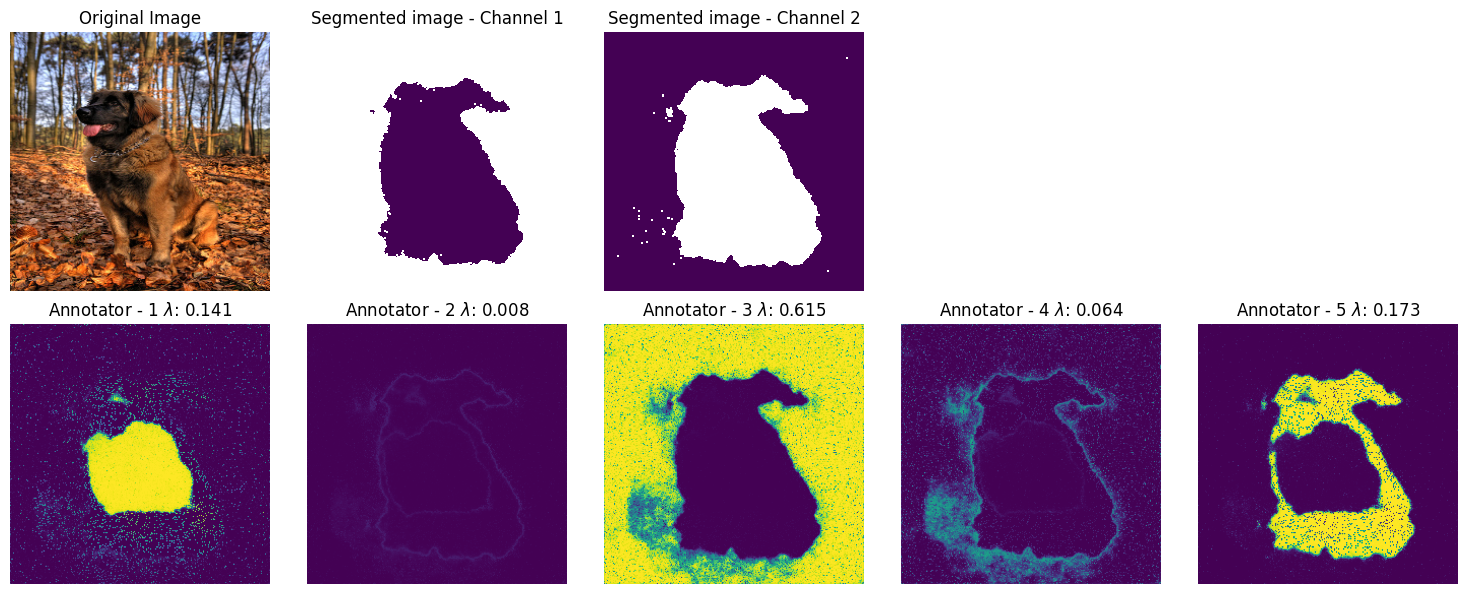

tf.Tensor(
[[0.99999994 0.99999994 0.9999999  ... 0.9999999  0.99999976 0.9999999 ]
 [1.         0.99999976 0.99999976 ... 0.9999999  0.99999994 0.9999998 ]
 [0.9999998  0.99999976 0.9999999  ... 1.         0.99999994 0.9999999 ]
 ...
 [0.9999999  0.9999998  0.9999998  ... 0.9999998  0.9999998  0.99999994]
 [0.99999994 1.         0.9999999  ... 0.9999998  0.99999994 1.0000001 ]
 [1.         0.99999994 1.         ... 0.99999994 1.         0.99999994]], shape=(256, 256), dtype=float32)
Learning Rate in epoch 30: 0.0010000000474974513
Epoch 31/100
Training time: 22.312s
Loss: 11.561, Dice: -0.880, Jaccard: 0.793, Specificity: 0.920, Sensitivity: 0.920
Val_Loss: 0.563, Val_Dice: -0.862, Val_Jaccard: 0.773, Val_Specificity: 0.875, Val_Sensitivity: 0.875
Epoch 32/100
Training time: 22.217s
Loss: 11.551, Dice: -0.883, Jaccard: 0.799, Specificity: 0.923, Sensitivity: 0.923
Val_Loss: 0.564, Val_Dice: -0.856, Val_Jaccard: 0.764, Val_Specificity: 0.864, Val_Sensitivity: 0.864
Epoch 33/100
Trainin

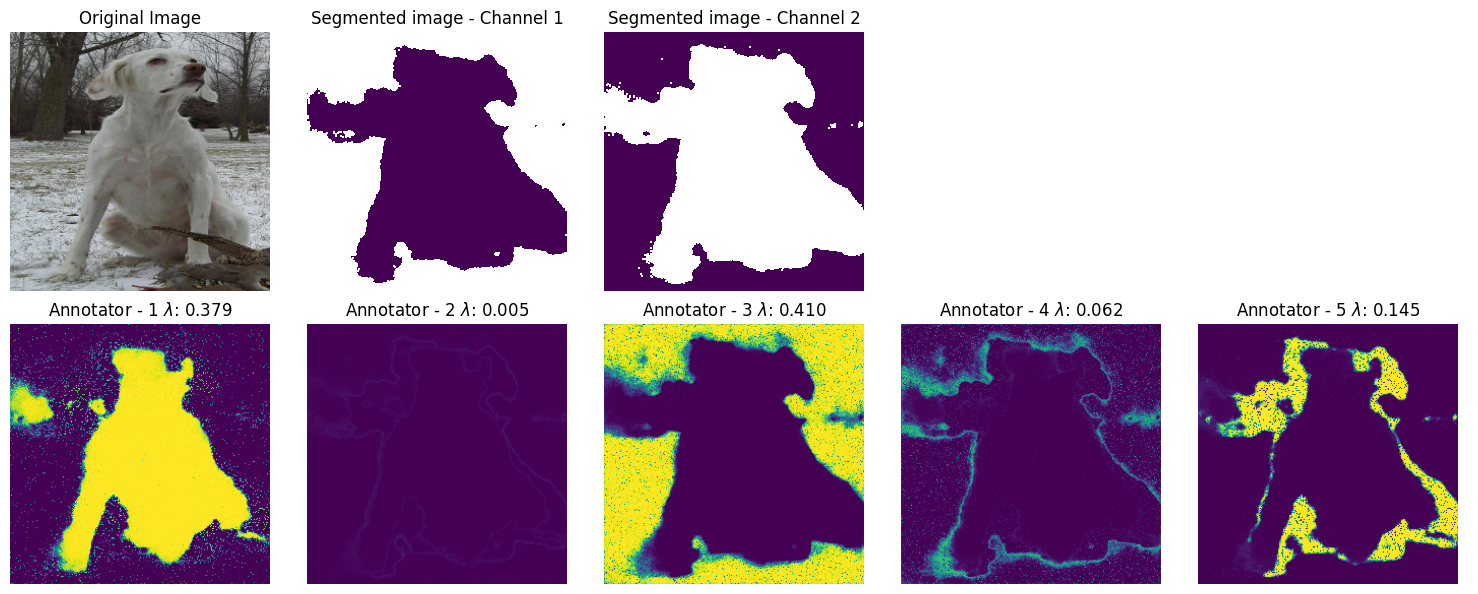

tf.Tensor(
[[1.         1.         0.9999999  ... 0.99999994 0.99999994 1.        ]
 [0.99999994 0.9999998  0.9999999  ... 0.9999999  0.99999976 0.9999998 ]
 [1.         0.99999994 0.9999997  ... 0.9999998  0.9999999  0.9999999 ]
 ...
 [1.         0.99999994 0.9999998  ... 0.9999999  0.9999999  0.9999999 ]
 [0.99999994 0.9999999  0.9999999  ... 0.9999999  0.99999976 0.99999994]
 [0.99999994 1.         1.         ... 0.9999998  0.9999999  0.9999999 ]], shape=(256, 256), dtype=float32)
Learning Rate in epoch 40: 0.0010000000474974513
Epoch 41/100
Training time: 23.683s
Loss: 11.490, Dice: -0.902, Jaccard: 0.828, Specificity: 0.934, Sensitivity: 0.934
Val_Loss: 0.565, Val_Dice: -0.856, Val_Jaccard: 0.764, Val_Specificity: 0.864, Val_Sensitivity: 0.864
Epoch 42/100
Training time: 23.244s
Loss: 11.486, Dice: -0.904, Jaccard: 0.830, Specificity: 0.935, Sensitivity: 0.935
Val_Loss: 0.566, Val_Dice: -0.857, Val_Jaccard: 0.768, Val_Specificity: 0.859, Val_Sensitivity: 0.859
Epoch 43/100
Trainin

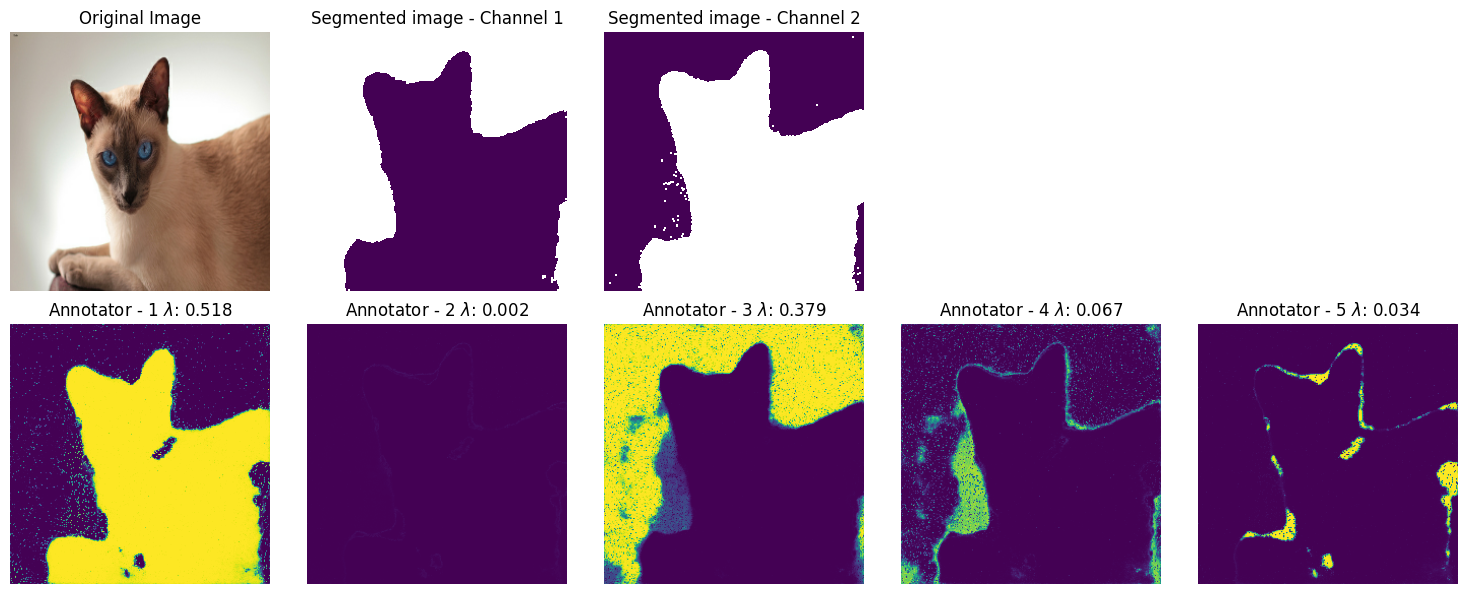

tf.Tensor(
[[0.99999994 0.99999994 1.         ... 1.         0.99999994 1.        ]
 [0.99999994 0.9999998  0.9999999  ... 0.9999998  1.         0.99999994]
 [0.9999999  0.99999994 0.9999999  ... 1.         0.99999994 0.9999999 ]
 ...
 [0.9999999  0.9999999  0.9999999  ... 0.9999999  1.         0.99999994]
 [0.99999994 0.9999999  0.9999999  ... 0.9999999  0.9999998  0.9999999 ]
 [0.99999994 0.9999999  0.99999994 ... 1.         0.9999999  0.9999999 ]], shape=(256, 256), dtype=float32)
Learning Rate in epoch 50: 0.0010000000474974513
Epoch 51/100
Training time: 22.370s
Loss: 11.465, Dice: -0.912, Jaccard: 0.843, Specificity: 0.939, Sensitivity: 0.939
Val_Loss: 0.568, Val_Dice: -0.852, Val_Jaccard: 0.761, Val_Specificity: 0.864, Val_Sensitivity: 0.864
Epoch 52/100
Training time: 22.482s
Loss: 11.460, Dice: -0.913, Jaccard: 0.844, Specificity: 0.940, Sensitivity: 0.940
Val_Loss: 0.570, Val_Dice: -0.853, Val_Jaccard: 0.763, Val_Specificity: 0.865, Val_Sensitivity: 0.865
Epoch 53/100
Trainin

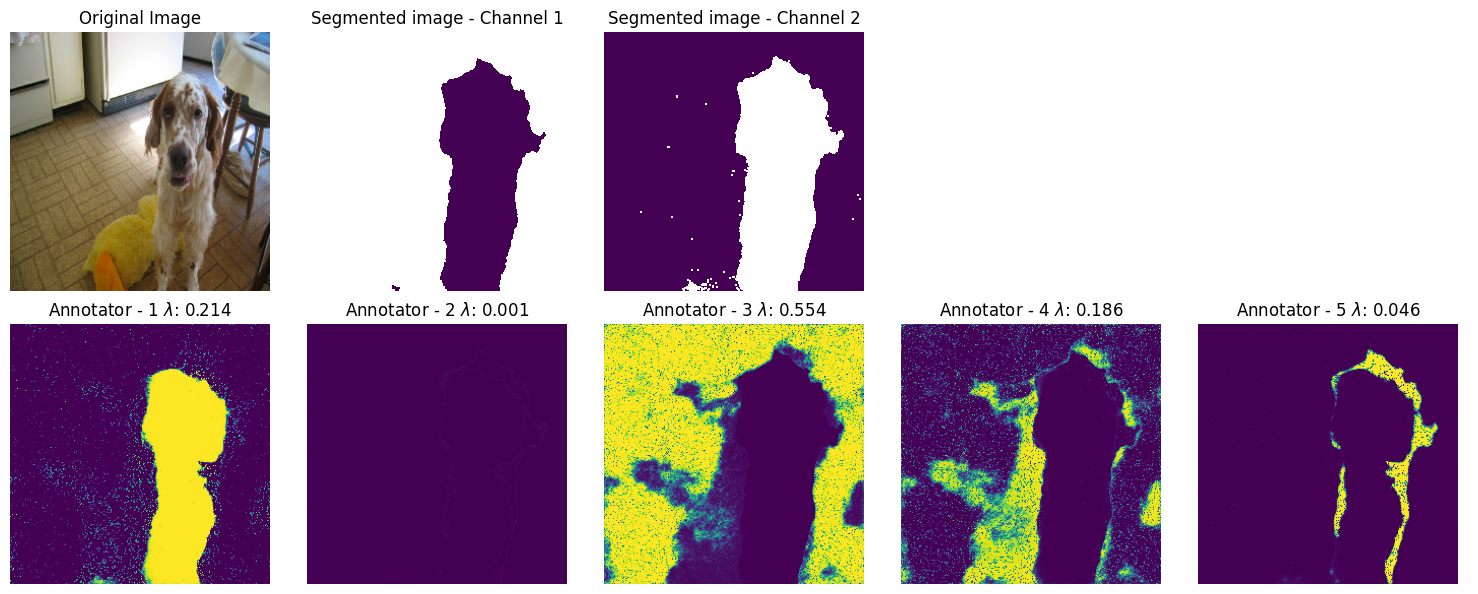

tf.Tensor(
[[1.0000001  0.99999994 0.9999999  ... 0.99999994 0.9999998  0.9999999 ]
 [0.9999999  0.9999999  0.99999994 ... 1.         0.9999999  0.9999999 ]
 [0.99999994 0.9999999  0.99999994 ... 0.99999994 1.         0.9999999 ]
 ...
 [0.99999994 0.9999999  0.99999994 ... 1.         0.99999994 0.9999998 ]
 [0.9999999  0.99999994 0.99999994 ... 0.9999999  0.99999994 0.99999976]
 [0.99999994 1.         0.99999994 ... 0.9999999  0.9999998  0.9999999 ]], shape=(256, 256), dtype=float32)
Learning Rate in epoch 60: 0.0010000000474974513
Epoch 61/100
Training time: 22.632s
Loss: 11.446, Dice: -0.918, Jaccard: 0.853, Specificity: 0.943, Sensitivity: 0.943
Val_Loss: 0.568, Val_Dice: -0.855, Val_Jaccard: 0.764, Val_Specificity: 0.867, Val_Sensitivity: 0.867
Epoch 62/100
Training time: 22.249s
Loss: 11.443, Dice: -0.920, Jaccard: 0.855, Specificity: 0.944, Sensitivity: 0.944
Val_Loss: 0.562, Val_Dice: -0.870, Val_Jaccard: 0.784, Val_Specificity: 0.881, Val_Sensitivity: 0.881
Epoch 63/100
Trainin

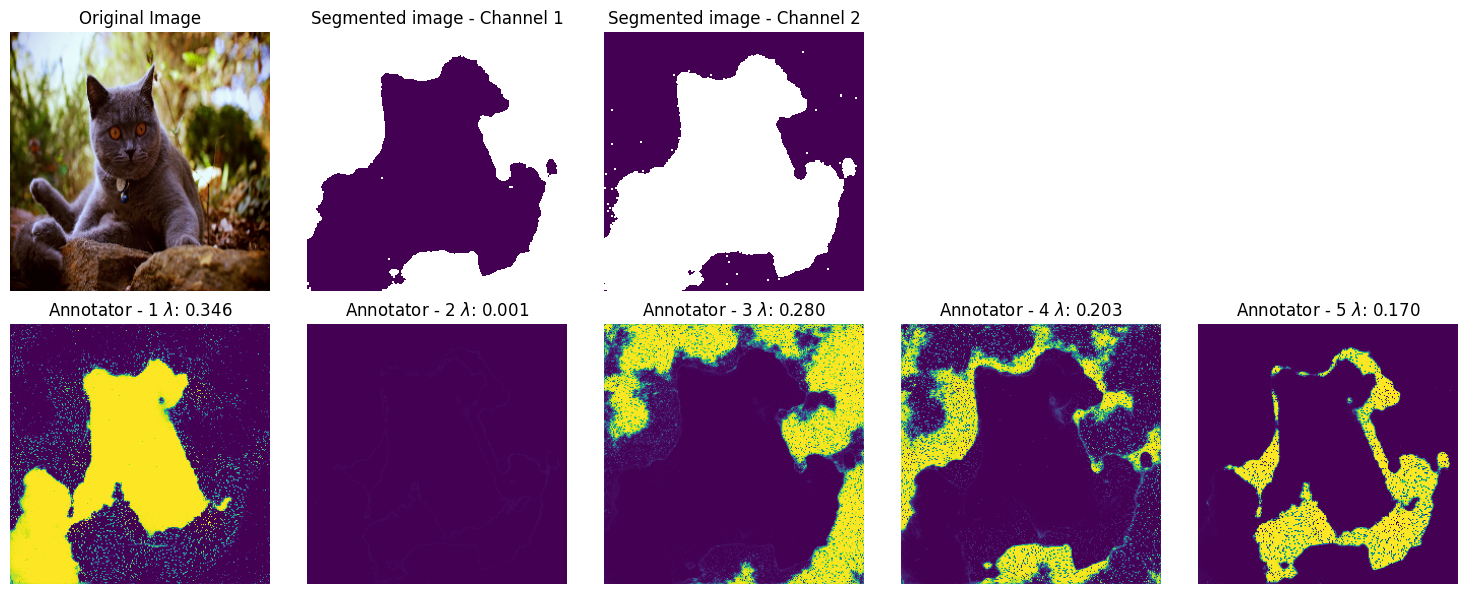

tf.Tensor(
[[1.         0.9999998  0.9999999  ... 0.99999994 0.9999999  0.9999999 ]
 [0.99999994 0.99999994 0.9999998  ... 0.9999998  0.99999976 1.        ]
 [0.99999994 0.9999998  0.9999999  ... 0.99999994 1.         0.9999998 ]
 ...
 [0.99999976 1.         0.9999999  ... 0.99999994 0.99999994 0.9999999 ]
 [0.9999999  0.99999994 0.9999999  ... 0.99999994 0.9999999  0.9999999 ]
 [0.9999999  0.9999998  1.         ... 0.9999999  1.0000001  0.9999999 ]], shape=(256, 256), dtype=float32)
Learning Rate in epoch 70: 0.0010000000474974513
Epoch 71/100
Training time: 22.446s
Loss: 11.405, Dice: -0.932, Jaccard: 0.875, Specificity: 0.952, Sensitivity: 0.952
Val_Loss: 0.570, Val_Dice: -0.868, Val_Jaccard: 0.784, Val_Specificity: 0.874, Val_Sensitivity: 0.874
Epoch 72/100
Training time: 22.761s
Loss: 11.403, Dice: -0.933, Jaccard: 0.878, Specificity: 0.953, Sensitivity: 0.953
Val_Loss: 0.567, Val_Dice: -0.881, Val_Jaccard: 0.803, Val_Specificity: 0.891, Val_Sensitivity: 0.891
Epoch 73/100
Trainin

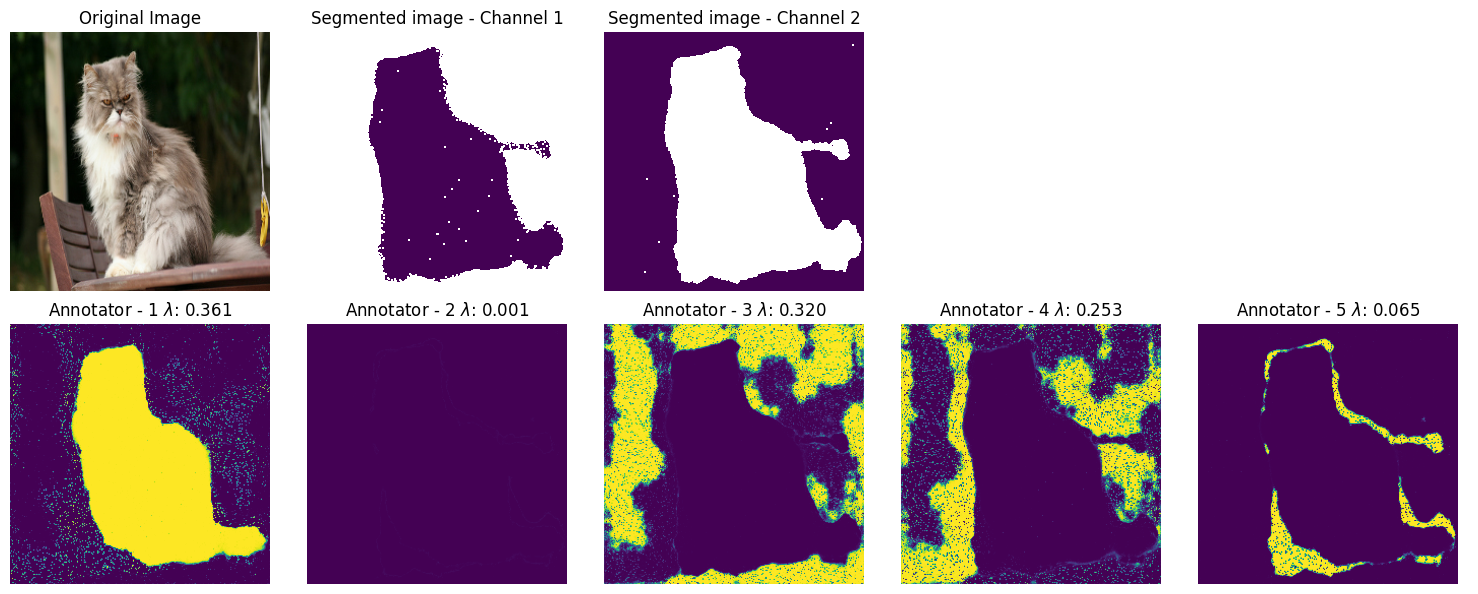

tf.Tensor(
[[0.9999999  0.9999999  1.         ... 0.9999999  0.99999994 0.9999998 ]
 [1.         0.9999999  0.9999998  ... 0.9999999  0.99999994 0.99999994]
 [0.9999999  0.9999998  1.         ... 0.99999976 0.9999999  0.99999994]
 ...
 [0.9999999  0.99999994 0.9999999  ... 0.9999998  0.9999999  0.99999976]
 [0.9999998  0.99999994 0.99999994 ... 0.9999999  0.9999998  0.9999999 ]
 [0.99999994 0.99999994 0.99999976 ... 0.99999994 0.99999994 1.        ]], shape=(256, 256), dtype=float32)
Learning Rate in epoch 80: 0.0010000000474974513
Epoch 81/100
Training time: 23.227s
Loss: 11.384, Dice: -0.939, Jaccard: 0.888, Specificity: 0.957, Sensitivity: 0.957
Val_Loss: 0.567, Val_Dice: -0.883, Val_Jaccard: 0.804, Val_Specificity: 0.894, Val_Sensitivity: 0.894
Epoch 82/100
Training time: 22.887s
Loss: 11.379, Dice: -0.942, Jaccard: 0.892, Specificity: 0.959, Sensitivity: 0.959
Val_Loss: 0.567, Val_Dice: -0.879, Val_Jaccard: 0.798, Val_Specificity: 0.890, Val_Sensitivity: 0.890
Epoch 83/100
Trainin

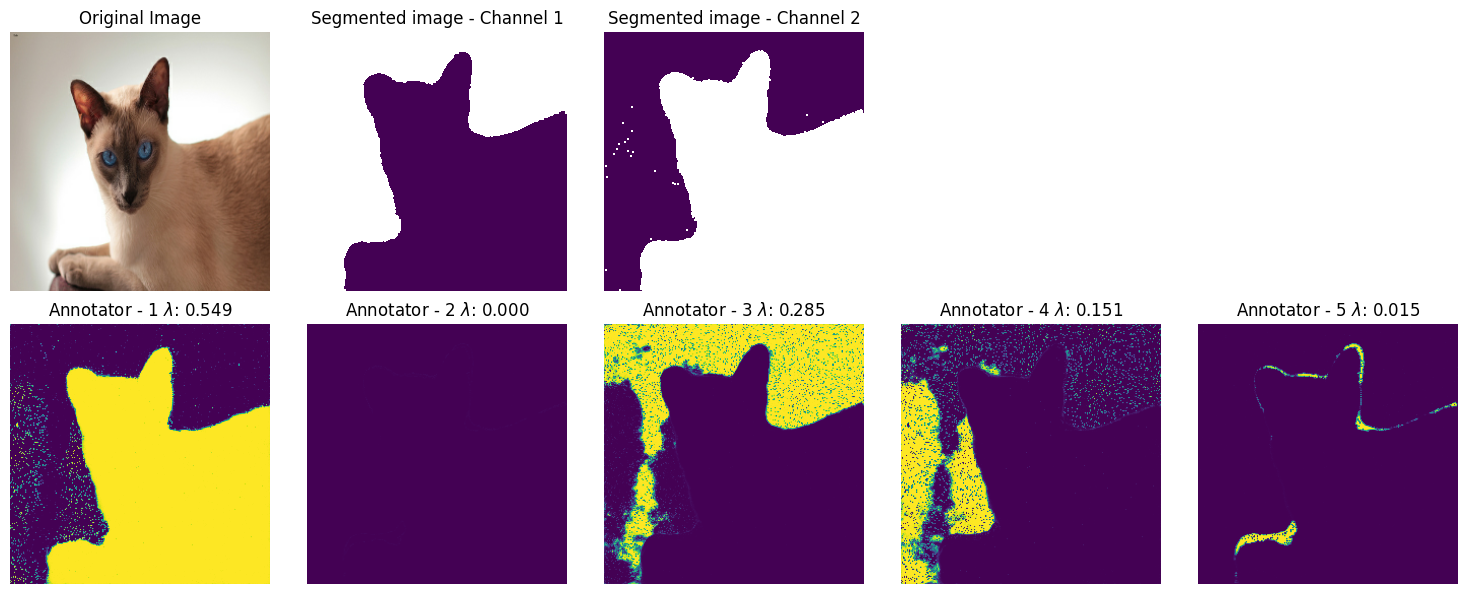

tf.Tensor(
[[0.9999999  0.99999994 0.9999999  ... 0.9999999  1.         0.9999998 ]
 [0.9999998  0.99999994 0.9999999  ... 0.99999976 0.9999998  0.99999994]
 [0.9999999  0.99999994 1.0000001  ... 0.9999999  1.         0.9999999 ]
 ...
 [0.99999994 1.         0.9999998  ... 0.99999994 0.9999999  0.99999994]
 [1.         0.9999999  0.99999994 ... 0.99999994 0.99999994 0.9999999 ]
 [0.99999994 0.99999994 0.9999999  ... 0.9999998  0.9999999  0.99999994]], shape=(256, 256), dtype=float32)
Learning Rate in epoch 90: 0.0010000000474974513
Epoch 91/100
Training time: 22.457s
Loss: 11.359, Dice: -0.948, Jaccard: 0.903, Specificity: 0.962, Sensitivity: 0.962
Val_Loss: 0.566, Val_Dice: -0.882, Val_Jaccard: 0.803, Val_Specificity: 0.886, Val_Sensitivity: 0.886
Epoch 92/100
Training time: 22.645s
Loss: 11.355, Dice: -0.949, Jaccard: 0.905, Specificity: 0.963, Sensitivity: 0.963
Val_Loss: 0.567, Val_Dice: -0.885, Val_Jaccard: 0.808, Val_Specificity: 0.888, Val_Sensitivity: 0.888
Epoch 93/100
Trainin

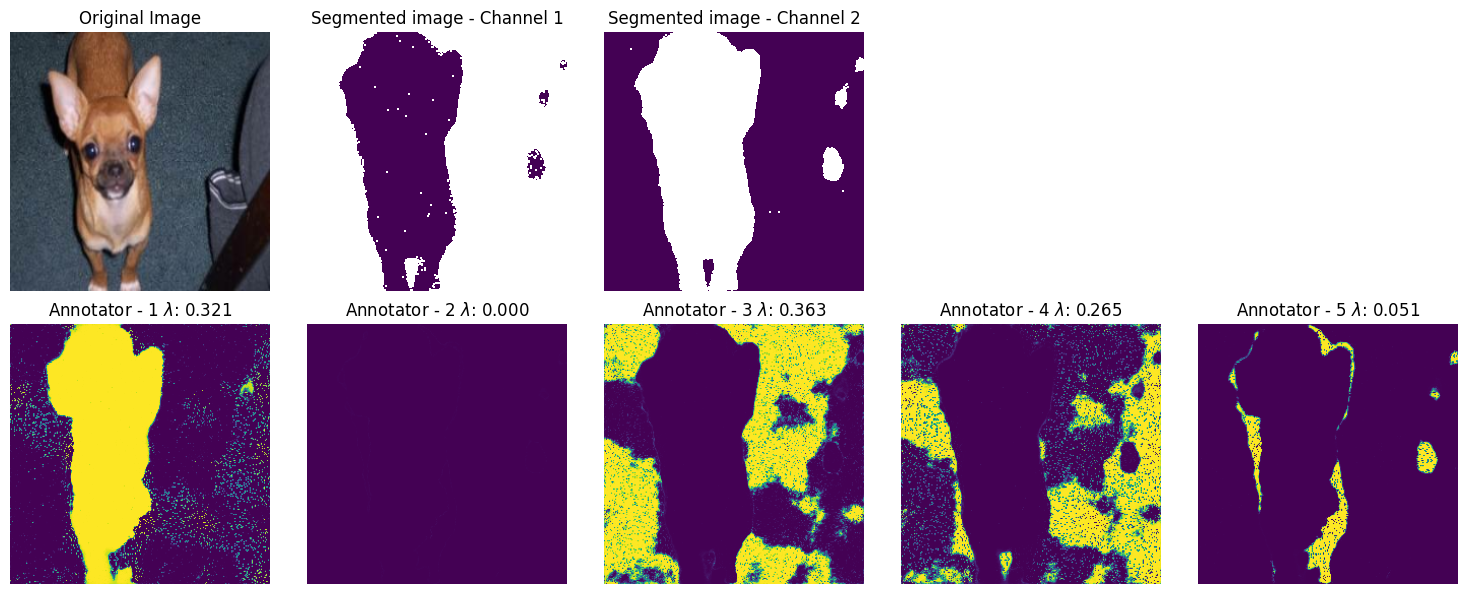

tf.Tensor(
[[0.99999976 0.9999998  0.9999999  ... 1.         0.9999999  0.99999994]
 [0.9999999  0.9999999  0.9999999  ... 1.         0.9999999  0.9999998 ]
 [0.9999998  0.99999994 0.9999998  ... 0.99999994 1.         0.99999994]
 ...
 [0.9999998  0.99999994 0.99999994 ... 0.99999994 0.99999994 0.9999999 ]
 [0.99999994 0.9999999  0.99999976 ... 0.9999998  1.         0.99999994]
 [0.9999999  0.9999998  0.99999994 ... 0.9999999  0.9999999  0.99999994]], shape=(256, 256), dtype=float32)
Learning Rate in epoch 100: 0.0010000000474974513


In [22]:
# Custom training function applying gradient descent

# Set random seed for numpy
np.random.seed(42)

# Set random seed for Tensorflow
tf.keras.backend.clear_session()
tf.random.set_seed(42)

batch_size = 32 # Define the batch size
optimizer = tf.keras.optimizers.Adam()#(learning_rate=0.001) # Define the optimizer
model_name = "UNET-TGCE_SS" # Define the model name for WanDB
loss_fn = TGCE_SS(q=0.1,R=NUM_ANNOTATORS,K_=2)# Define the loss function
dice_metric_train = DiceCoefficientMetric()
dice_metric_val = DiceCoefficientMetric()
jaccard_metric_train = Jaccard()
jaccard_metric_val = Jaccard()
specificity_metric_train = Specificity()
specificity_metric_val = Specificity()
sensitivity_metric_train = Sensitivity()
sensitivity_metric_val = Sensitivity()

num_epochs = 100 # Number of epochs
lambda1, lambda2 = 0, 0 #1e-3,1e-3
X_val_1 = np.array(X_val[3])
y_val_1 = np.array(y_val[3])

#wandb.login(key="5092b6e1a9fb50d7448b32f2db4d0163bb5ef14f")
#run = wandb.init(config=None, project='Segmentacion_TGCE_SS', entity='gcpds')
#wandb.config.dataset_name = "OxfordPet-Lite-IMG-Mask"
#wandb.config.architecture_name = "UNET-TGCE_SS"

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    start_time = time.time()
    
    epoch_train_loss = 0.0  # Initialize accumulated loss for this epoch
    epoch_train_dice = 0.0  # Initialize accumulated Dice coefficient for this epoch
    epoch_train_jaccard = 0.0
    epoch_train_specificity = 0.0
    epoch_train_sensitivity = 0.0
    
    epoch_val_loss = 0.0
    epoch_val_dice = 0.0
    epoch_val_jaccard = 0.0
    epoch_val_specificity = 0.0
    epoch_val_sensitivity = 0.0
    
    # Reset the state of the metric at the beginning of each epoch
    dice_metric_train.reset_states()
    dice_metric_val.reset_states()
    
    jaccard_metric_train.reset_states()
    jaccard_metric_val.reset_states()
    
    specificity_metric_train.reset_states()
    specificity_metric_val.reset_states()
    
    sensitivity_metric_train.reset_states()
    sensitivity_metric_val.reset_states()
    
    for k in range(len(X_train)):
      X_train_1 = np.array(X_train[k])
      y_train_1 = np.array(y_train[k])
      # Iterate over training data in batches
      for i in range(0, len(X_train_1), batch_size):
          x_batch = X_train_1[i:i+batch_size]
          y_batch = y_train_1[i:i+batch_size]
          y_batch[y_batch < 0.5] = 0 # Thresholding
          y_batch[y_batch >= 0.5] = 1
        
          with tf.GradientTape() as tape:
              # Make prediction
              predictions = model(x_batch, training=True)
              # Calculate the loss with L1 and L2 regularitazion
              loss, term_r, term_c = loss_fn.call(y_batch, predictions)
              reg_loss = compute_regularization_loss(model, lambda1, lambda2)
              total_loss = loss + reg_loss
              # dice = dice_fn.call(y_batch, predictions)

          # Calculate the gradient of the loss with respect to the model's parameters
          gradients = tape.gradient(total_loss, model.trainable_variables)

          # Update model weights using the optimizer
          optimizer.apply_gradients(zip(gradients, model.trainable_variables))

          # Accumulate the loss of this batch
          epoch_train_loss += total_loss.numpy()  # Convert loss tensor to numeric value
          # epoch_dice += dice.numpy()
        
          array_ybatch = y_batch[..., :2]
          array_ybatch = array_ybatch[...,0] 
          
          # Convert tensor to a NumPy array
          array_predictions = predictions.numpy()

          # Select the first two channels of the array
          array_predictions = array_predictions[..., :2]
            
          # Calculate metrics and update its state
          dice_metric_train.update_state(array_ybatch, array_predictions)
          jaccard_metric_train.update_state(array_ybatch, array_predictions)
          specificity_metric_train.update_state(array_ybatch, array_predictions)
          sensitivity_metric_train.update_state(array_ybatch, array_predictions)
            
    # Get the Dice metric value at the end of each epoch
    epoch_train_dice = dice_metric_train.result()
    epoch_train_jaccard = jaccard_metric_train.result()
    epoch_train_specificity = specificity_metric_train.result()
    epoch_train_sensitivity = sensitivity_metric_train.result()
            
    for i in range(0, len(X_val_1), batch_size):
          x_batch_val = X_val_1[i:i+batch_size]
          y_batch_val = y_val_1[i:i+batch_size]
          y_batch_val[y_batch_val < 0.5] = 0 # Thresholding
          y_batch_val[y_batch_val >= 0.5] = 1
        
          # Make predictions
          val_predictions = model(x_batch_val, training=False)
    
          # Calculate the loss with L1 and L2 regularitazion
          val_loss, _, _ = loss_fn.call(y_batch_val, val_predictions)
          val_total_loss = val_loss + reg_loss

          # Accumulate the loss of this batch
          epoch_val_loss += val_total_loss.numpy()  # Convert loss tensor to numeric value
        
          array_ybatch_val = y_batch_val[..., :2]
          array_ybatch_val = array_ybatch_val[...,0] 
          
          # Convert tensor to a NumPy array
          array_predictions_val = val_predictions.numpy()

          # Select the first two channels of the array
          array_predictions_val = array_predictions_val[..., :2]
            
          # Calculate metrics and update its state
          dice_metric_val.update_state(array_ybatch_val, array_predictions_val)
          jaccard_metric_val.update_state(array_ybatch_val, array_predictions_val)
          specificity_metric_val.update_state(array_ybatch_val, array_predictions_val)
          sensitivity_metric_val.update_state(array_ybatch_val, array_predictions_val)

    # Get the Dice metric value for validation batch at the end of each epoch
    epoch_val_dice = dice_metric_val.result()
    epoch_val_jaccard = jaccard_metric_val.result()
    epoch_val_specificity = specificity_metric_val.result()
    epoch_val_sensitivity = sensitivity_metric_val.result()    
    
    # Get epoch training time
    end_time = time.time()
    execution_time = end_time - start_time
    # Print the execution time, loss value, and Dice value for each epoch
    print(f"Training time: {execution_time:.3f}s")
    print(f"Loss: {epoch_train_loss:.3f}, Dice: {epoch_train_dice:.3f}, Jaccard: {epoch_train_jaccard:.3f}, Specificity: {epoch_train_specificity:.3f}, Sensitivity: {epoch_train_sensitivity:.3f}")
    print(f"Val_Loss: {epoch_val_loss:.3f}, Val_Dice: {epoch_val_dice:.3f}, Val_Jaccard: {epoch_val_jaccard:.3f}, Val_Specificity: {epoch_val_specificity:.3f}, Val_Sensitivity: {epoch_val_sensitivity:.3f}")
    #wandb.log({'epoch': epoch, 'loss-TGCE_SS':epoch_loss, 'DiceCoefficient': dice_result})
    if (epoch + 1) % 10 == 0:
        num_img_batch = num_img_pred = random.randint(0, batch_size - 1)
        plotter_fn(predictions,x_batch,num_img_batch, num_img_pred)  # Plot predictions
        current_lr = optimizer.learning_rate.numpy()  # Get current learning rate
        print(f"Learning Rate in epoch {epoch+1}: {current_lr}")
    if tf.math.is_nan(loss):
        print("====================================================================\n",term_r,"====================================================================\n",term_r,"====================================================================\n")

model.save(f'{model_name}.keras')
#wandb.save(f'{model_name}.h5')
#run.finish()  # Finish W&B logging at the end of training

In [23]:
# Model's prediction for a sample

X_test_1 = X_test[0]
prediction = model.predict(X_test_1[1:2,:,:,:])

1/1 [==============================] - 1s 1s/step


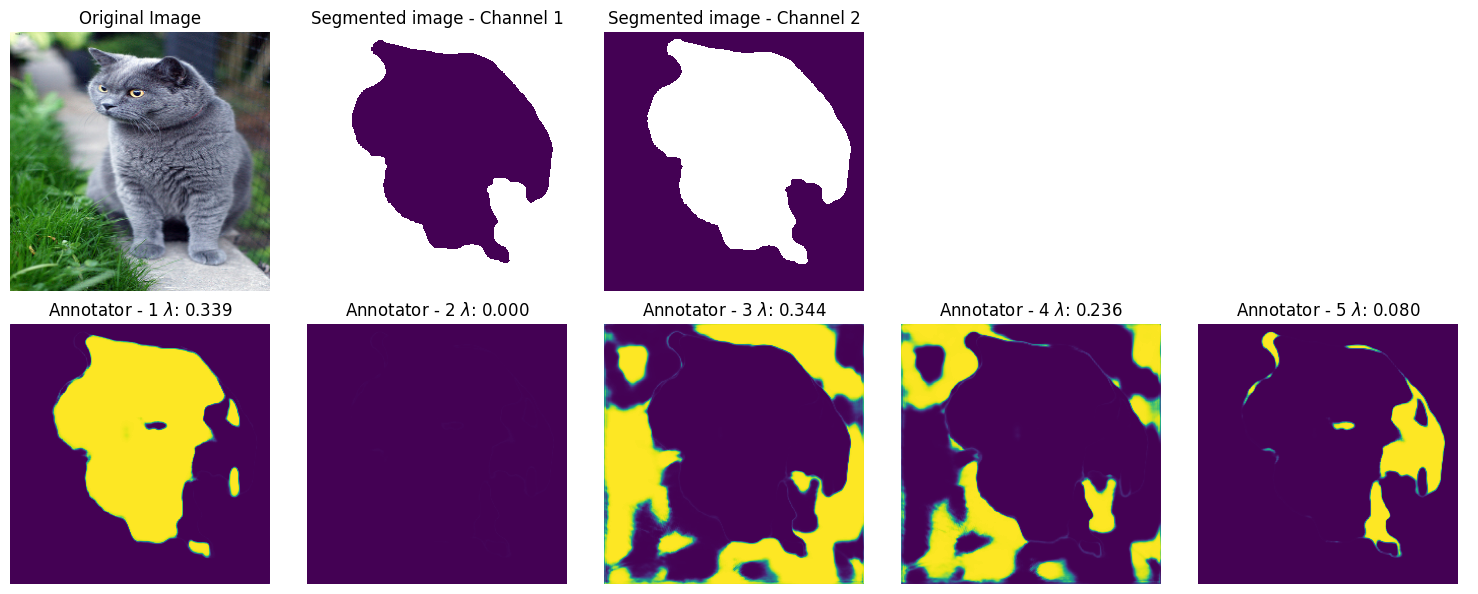

tf.Tensor(
[[0.9999999  1.         0.9999999  ... 0.99999994 1.         0.99999994]
 [0.99999994 0.9999998  0.9999999  ... 0.99999994 0.9999999  1.        ]
 [0.9999998  0.9999998  0.99999994 ... 0.9999998  0.9999999  0.99999994]
 ...
 [0.9999999  1.         0.99999994 ... 0.9999998  0.99999994 0.9999999 ]
 [0.9999999  1.         0.99999994 ... 0.9999998  0.99999994 0.9999999 ]
 [1.         0.9999998  1.         ... 0.99999976 0.99999994 0.9999998 ]], shape=(256, 256), dtype=float32)


In [24]:
plotter_fn(prediction,X_test_1,1,0)